# Core Workflow: Building Training Data
Construct and store training data using specified input stack, for any number of input sets (ie "image suffixes"). Presumes prior acquisition/preparation of both ground-truth and image files. Note that tiling must be consistent across ground-truth, imagery, and training data construction.
  
Date: 2018-09-12  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [10]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import ogr, gdal
import math
from skimage import measure
from skimage import filters
from scipy import stats


import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [16]:
place = 'hyderabad'

data_root='/data/phase_iii/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=5  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

ndvi_bands = ['raw'];

tile_resolution = resolution
tile_size = 256
tile_pad = 16

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

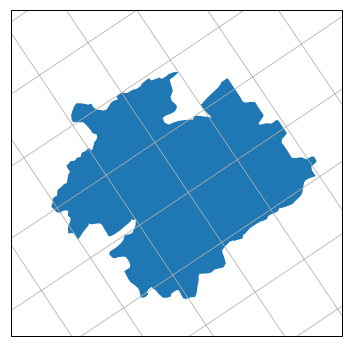

In [17]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 1687
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.15379176547472, 17.552665220579843], [78.16734375580529, 17.552859679408396], [78.16714143788593, 17.565859911723514], [78.15358848280565, 17.56566529977946], [78.15379176547472, 17.552665220579843]]]}


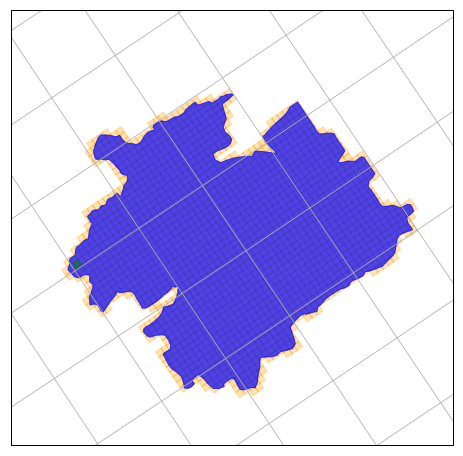

In [18]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Inspect ground truth files

In [19]:
label_stats = {}
for tile_id in range(len(tiles['features'])):
    tile = tiles['features'][tile_id]
    #label_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_'+label_suffix+'.tif'
    label_file = data_path+place+'_tile'+str(tile_id).zfill(4)+'_'+label_suffix+'_'+str(resolution)+'m'+'.tif'
    label_stats[tile_id] = util_rasters.stats_byte_raster(label_file, category_label, show=False)

categories = [0,1,2,3,4,5,6]

stats = {}
for c in categories:
    stats[c] = 0

for tile_id in label_stats.keys():
    if label_stats[tile_id][255] != 73984: # (8 + 256 + 8)^2
        print tile_id, label_stats[tile_id]
    for c in categories:
        try:
            stats[c] = stats[c] + label_stats[tile_id][c]
        except:
            continue

print stats

/data/phase_iii/hyderabad/hyderabad_tile0000_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0001_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0002_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0003_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0004_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0005_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0006_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0007_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0008_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0009_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0010_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0011_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0012_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0113_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0114_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0115_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0116_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0117_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0118_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0119_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0120_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0121_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0122_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0123_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0124_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0125_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0226_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0227_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0228_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0229_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0230_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0231_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0232_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0233_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0234_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0235_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0236_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0237_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0238_aue_5m.tif
255 82944 No Label
/data/

255 78938 No Label
/data/phase_iii/hyderabad/hyderabad_tile0335_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0336_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0337_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0338_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0339_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0340_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0341_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0342_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0343_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0344_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0345_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0346_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0347_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0437_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0438_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0439_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0440_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0441_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0442_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0443_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0444_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0445_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0446_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0447_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0448_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0449_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0549_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0550_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0551_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0552_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0553_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0554_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0555_aue_5m.tif
0 147 Open Space
1 358 Non-Residential
2 180 Residential Atomistic
3 983 Residential Informal Subdivision
6 466 Roads
255 80810 No Label
/data/phase_iii/hyderabad/hyderabad_tile0556_aue_5m.tif
0 192 Open Space
1 314 Non-Residential
2 151 Residential Atomistic
3 2540 Residential Informal Subdivision
6 659 Roads
255 79088 No Label
/data/phase_iii/hyderabad/hyderabad_tile0557_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0558_aue_5m.tif
255 82944 No 

255 82580 No Label
/data/phase_iii/hyderabad/hyderabad_tile0653_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0654_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0655_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0656_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0657_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0658_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0659_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0660_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0661_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0662_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0663_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0664_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0665_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0757_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0758_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0759_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0760_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0761_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0762_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0763_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0764_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0765_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0766_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0767_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0768_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0769_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0858_aue_5m.tif
0 762 Open Space
1 366 Non-Residential
2 1746 Residential Atomistic
4 630 Residential Formal Subdivision
6 507 Roads
255 78933 No Label
/data/phase_iii/hyderabad/hyderabad_tile0859_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0860_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0861_aue_5m.tif
0 546 Open Space
1 158 Non-Residential
4 874 Residential Formal Subdivision
6 208 Roads
255 81158 No Label
/data/phase_iii/hyderabad/hyderabad_tile0862_aue_5m.tif
0 291 Open Space
1 243 Non-Residential
4 508 Residential Formal Subdivision
6 241 Roads
255 81661 No Label
/data/phase_iii/hyderabad/hyderabad_tile0863_aue_5m.tif
0 648 Open Space
1 343 Non-Residential
2 22 Residential Atomistic
4 2319 Residential Formal Subdivision
6 672 Roads
255 78940 No Label
/data/phase_iii/hyderabad/hyderabad_tile0864_aue_5m.tif
0 1891 Open Space
1 1788 Non-Residential
6 323 Roads
255 78942 No 

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0946_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0947_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0948_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0949_aue_5m.tif
0 1850 Open Space
3 1662 Residential Informal Subdivision
6 368 Roads
255 79064 No Label
/data/phase_iii/hyderabad/hyderabad_tile0950_aue_5m.tif
0 80 Open Space
3 1712 Residential Informal Subdivision
6 295 Roads
255 80857 No Label
/data/phase_iii/hyderabad/hyderabad_tile0951_aue_5m.tif
0 1911 Open Space
1 280 Non-Residential
2 10 Residential Atomistic
3 582 Residential Informal Subdivision
4 717 Residential Formal Subdivision
6 502 Roads
255 78942 No Label
/data/phase_iii/hyderabad/hyderabad_tile0952_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0953_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile0954_aue_5m.tif
255 82944 No Label
/data/phase_i

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1036_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1037_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1038_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1039_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1040_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1041_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1042_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1043_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1044_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1045_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1046_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1047_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1048_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1128_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1129_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1130_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1131_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1132_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1133_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1134_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1135_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1136_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1137_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1138_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1139_aue_5m.tif
0 1927 Open Space
1 1401 Non-Residential
2 61 Residential Atomistic
3 127 Residential Informal Subdi

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1219_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1220_aue_5m.tif
4 3020 Residential Formal Subdivision
6 977 Roads
255 78947 No Label
/data/phase_iii/hyderabad/hyderabad_tile1221_aue_5m.tif
0 130 Open Space
1 4 Non-Residential
4 2607 Residential Formal Subdivision
6 621 Roads
255 79582 No Label
/data/phase_iii/hyderabad/hyderabad_tile1222_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1223_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1224_aue_5m.tif
0 1955 Open Space
1 966 Non-Residential
4 614 Residential Formal Subdivision
6 477 Roads
255 78932 No Label
/data/phase_iii/hyderabad/hyderabad_tile1225_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1226_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1227_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1228_aue_5m.tif
255 82944 No Label
/data

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1316_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1317_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1318_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1319_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1320_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1321_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1322_aue_5m.tif
0 2664 Open Space
1 241 Non-Residential
6 239 Roads
255 79800 No Label
/data/phase_iii/hyderabad/hyderabad_tile1323_aue_5m.tif
0 2222 Open Space
1 630 Non-Residential
6 210 Roads
255 79882 No Label
/data/phase_iii/hyderabad/hyderabad_tile1324_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1325_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1326_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1327_aue_5m.

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1422_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1423_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1424_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1425_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1426_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1427_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1428_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1429_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1430_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1431_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1432_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1433_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1434_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1532_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1533_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1534_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1535_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1536_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1537_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1538_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1539_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1540_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1541_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1542_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1543_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1544_aue_5m.tif
255 82944 No Label
/data/

255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1642_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1643_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1644_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1645_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1646_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1647_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1648_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1649_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1650_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1651_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1652_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1653_aue_5m.tif
255 82944 No Label
/data/phase_iii/hyderabad/hyderabad_tile1654_aue_5m.tif
255 82944 No Label
/data/

814 {255: 82944}
815 {255: 82944}
816 {255: 82944}
817 {255: 82944}
818 {0: 292, 1: 1347, 4: 1537, 6: 840, 255: 78928}
819 {0: 46, 1: 254, 4: 315, 6: 233, 255: 82096}
820 {255: 82944}
821 {255: 82944}
822 {0: 1678, 1: 2034, 3: 31, 6: 269, 255: 78932}
823 {0: 276, 1: 257, 6: 35, 255: 82376}
824 {255: 82944}
825 {255: 82944}
826 {255: 82944}
827 {0: 424, 1: 1705, 2: 7, 3: 341, 4: 841, 6: 686, 255: 78940}
828 {255: 82944}
829 {255: 82944}
830 {255: 82944}
831 {255: 82944}
832 {255: 82944}
833 {255: 82944}
834 {255: 82944}
835 {255: 82944}
836 {255: 82944}
837 {255: 82944}
838 {255: 82944}
839 {255: 82944}
840 {255: 82944}
841 {255: 82944}
842 {255: 82944}
843 {255: 82944}
844 {255: 82944}
845 {255: 82944}
846 {255: 82944}
847 {255: 82944}
848 {255: 82944}
849 {255: 82944}
850 {255: 82944}
851 {255: 82944}
852 {0: 1718, 1: 205, 2: 4, 3: 1360, 6: 414, 255: 79243}
853 {3: 90, 6: 35, 255: 82819}
854 {0: 1631, 1: 1304, 2: 271, 3: 236, 6: 563, 255: 78939}
855 {255: 82944}
856 {255: 82944}
857 {

### Set training data construction parameters

In [3]:
window = 17    # width of square window

bands_vir=bands[:-1]
bands_sar=None
bands_ndvi=ndvi_bands
bands_ndbi=None
bands_osm=None

haze_removal = False

image_suffix_list = ['A']

### Execute preparatory functions

In [4]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+sar 8


### Build training data
Drawing on specified imagery to construct input stack according to parameters. Use input stack in combination with label file data to prepare and store training samples tile by tile. Combine per-tile training samples into single X and Y arrays. Split these combined arrays into training and validation sets, using a consistent permutation to preserve validation set integrity.

In [9]:
reload(util_workflow)
for image_suffix in image_suffix_list:
    print 'Constructing dataset tiles for ' + place.title() + ' image ' + image_suffix + ' using ground-truth \'' + label_suffix + '\' and input stack \'' + stack_label + '\''
    print ''
    util_workflow.construct_dataset_tiles(data_path, place, tiles, label_stats, image_suffix,
        window, stack_label, feature_count,
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,
        haze_removal=False,
        label_suffix=label_suffix, 
        category_label=category_label )
    
    print 'Combine dataset tiles into complete data arrays'
    X_data, Y_data = util_workflow.combine_dataset_tiles(data_path, place, tiles, label_suffix, image_suffix, stack_label, window)
    
    print 'Write complete datasets to file'
    util_workflow.split_dataset(data_path, place, label_suffix, stack_label, image_suffix, window)
    print ''

Constructing dataset tiles for Hyderabad image A using ground-truth 'aue' and input stack 'vir+sar'

Feature count: 8
Stack label:  vir+sar
tile 73 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1119 - 0.3035 )
vir band 1 into imn band 1 ( 0.0925 - 0.3105 )
vir band 2 into imn band 2 ( 0.0698 - 0.3565 )
vir band 3 into imn band 3 ( 0.0599 - 0.4261 )
vir band 4 into imn band 4 ( 0.0211 - 0.47 )
vir band 5 into imn band 5 ( 0.0137 - 0.4336 )
tile 73 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
tile 73 load labels
/data/phase_iii/hyderabad/hyderabad_tile073_aue.tif
y.shape (9, 288, 288)
0 214 Open Space
1 471 Non-Residential
2 0 Residential Atomistic
3 5 Residential Informal Subdivision
4 142 Residential Formal Subdivision
5 0 Residential Housing Project
6 166 Roads
7 82944 Study Area
8 998 Labeled

sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
tile 139 load labels
/data/phase_iii/hyderabad/hyderabad_tile139_aue.tif
y.shape (9, 288, 288)
0 139 Open Space
1 770 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 90 Roads
7 82944 Study Area
8 999 Labeled Study Area
tile 139 collect data,label samples
n_samples, sum {0: 139, 1: 770, 2: 0, 3: 0, 4: 0, 5: 0, 6: 90} 999
X,Y shapes (999, 392) (999,)
0 0 139
0 139 (139, 392) (139,)
1 1 770
1 909 (770, 392) (770,)
6 6 90
6 999 (90, 392) (90,)
(999, 392) (999,) float32
/data/phase_iii/hyderabad/hyderabad_tile139_aue_vir+sar_7w_A.pkl
tile 139 done

tile 156 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1104 - 0.3227 )
vir band 1 into imn band 1 ( 0.0905 - 0.3315 )
vir ban

tile 175 done

tile 181 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1182 - 0.3052 )
vir band 1 into imn band 1 ( 0.0968 - 0.3513 )
vir band 2 into imn band 2 ( 0.0761 - 0.4268 )
vir band 3 into imn band 3 ( 0.0649 - 0.478 )
vir band 4 into imn band 4 ( 0.0246 - 0.4502 )
vir band 5 into imn band 5 ( 0.0142 - 0.446 )
tile 181 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
tile 181 load labels
/data/phase_iii/hyderabad/hyderabad_tile181_aue.tif
y.shape (9, 288, 288)
0 381 Open Space
1 66 Non-Residential
2 4 Residential Atomistic
3 361 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 197 Roads
7 82944 Study Area
8 1009 Labeled Study Area
tile 181 collect data,label samples
n_samples, sum {0: 381, 1: 66, 2: 4, 3: 361, 4: 0, 5: 0, 6: 197} 1009
X,Y 

tile 203 done

tile 204 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1127 - 0.2633 )
vir band 1 into imn band 1 ( 0.0934 - 0.2877 )
vir band 2 into imn band 2 ( 0.071 - 0.3249 )
vir band 3 into imn band 3 ( 0.083 - 0.4526 )
vir band 4 into imn band 4 ( 0.0264 - 0.446 )
vir band 5 into imn band 5 ( 0.0165 - 0.4072 )
tile 204 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
tile 204 load labels
/data/phase_iii/hyderabad/hyderabad_tile204_aue.tif
y.shape (9, 288, 288)
0 642 Open Space
1 48 Non-Residential
2 3 Residential Atomistic
3 242 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 63 Roads
7 82944 Study Area
8 998 Labeled Study Area
tile 204 collect data,label samples
n_samples, sum {0: 642, 1: 48, 2: 3, 3: 242, 4: 0, 5: 0, 6: 63} 998
X,Y shape

0 0 246
0 246 (246, 392) (246,)
1 1 434
1 680 (434, 392) (434,)
2 2 446
2 1126 (446, 392) (446,)
4 4 560
4 1686 (560, 392) (560,)
6 6 309
6 1995 (309, 392) (309,)
(1995, 392) (1995,) float32
/data/phase_iii/hyderabad/hyderabad_tile226_aue_vir+sar_7w_A.pkl
tile 226 done

tile 227 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1107 - 0.341 )
vir band 1 into imn band 1 ( 0.0913 - 0.3506 )
vir band 2 into imn band 2 ( 0.0707 - 0.4279 )
vir band 3 into imn band 3 ( 0.0621 - 0.4542 )
vir band 4 into imn band 4 ( 0.0287 - 0.4317 )
vir band 5 into imn band 5 ( 0.0199 - 0.3875 )
tile 227 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 288, 288) 8
tile 227 load labels
/data/phase_iii/hyderabad/hyderabad_tile227_aue.tif
y.shape (9, 288, 288)
0 191 Open Space
1 155 Non-Residential
2 0 Residential Atomistic
3 0 Residential

82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1085 - 0.2587 )
vir band 1 into imn band 1 ( 0.086 - 0.2711 )
vir band 2 into imn band 2 ( 0.0671 - 0.3071 )
vir band 3 into imn band 3 ( 0.0553 - 0.3993 )
vir band 4 into imn band 4 ( 0.0263 - 0.4497 )
vir band 5 into imn band 5 ( 0.017 - 0.4413 )
tile 244 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
tile 244 load labels
/data/phase_iii/hyderabad/hyderabad_tile244_aue.tif
y.shape (9, 288, 288)
0 613 Open Space
1 97 Non-Residential
2 1 Residential Atomistic
3 220 Residential Informal Subdivision
4 634 Residential Formal Subdivision
5 0 Residential Housing Project
6 204 Roads
7 82944 Study Area
8 1769 Labeled Study Area
tile 244 collect data,label samples
n_samples, sum {0: 613, 1: 97, 2: 1, 3: 220, 4: 634, 5: 0, 6: 204} 1769
X,Y shapes (1769, 392) (1769,)
0 0 613
0 613 (613, 392) (613,)
1

tile 251 done

tile 252 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1165 - 0.2471 )
vir band 1 into imn band 1 ( 0.0906 - 0.2603 )
vir band 2 into imn band 2 ( 0.0765 - 0.3088 )
vir band 3 into imn band 3 ( 0.081 - 0.3257 )
vir band 4 into imn band 4 ( 0.0887 - 0.4121 )
vir band 5 into imn band 5 ( 0.0599 - 0.5082 )
tile 252 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.023529412 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 288, 288) 8
tile 252 load labels
/data/phase_iii/hyderabad/hyderabad_tile252_aue.tif
y.shape (9, 288, 288)
0 726 Open Space
1 108 Non-Residential
2 3 Residential Atomistic
3 592 Residential Informal Subdivision
4 362 Residential Formal Subdivision
5 0 Residential Housing Project
6 302 Roads
7 82944 Study Area
8 2093 Labeled Study Area
tile 252 collect data,label samples
n_samples, sum {0: 726, 1: 108, 2: 3, 3: 592, 4: 362, 5: 0, 6: 302} 20

1 168 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 692 Residential Formal Subdivision
5 0 Residential Housing Project
6 133 Roads
7 82944 Study Area
8 998 Labeled Study Area
tile 269 collect data,label samples
n_samples, sum {0: 5, 1: 168, 2: 0, 3: 0, 4: 692, 5: 0, 6: 133} 998
X,Y shapes (998, 392) (998,)
0 0 5
0 5 (5, 392) (5,)
1 1 168
1 173 (168, 392) (168,)
4 4 692
4 865 (692, 392) (692,)
6 6 133
6 998 (133, 392) (133,)
(998, 392) (998,) float32
/data/phase_iii/hyderabad/hyderabad_tile269_aue_vir+sar_7w_A.pkl
tile 269 done

tile 270 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1118 - 0.2693 )
vir band 1 into imn band 1 ( 0.0912 - 0.2784 )
vir band 2 into imn band 2 ( 0.0671 - 0.3191 )
vir band 3 into imn band 3 ( 0.0676 - 0.4413 )
vir band 4 into imn band 4 ( 0.0139 - 0.3982 )
vir band 5 into imn band 5 ( 0.0075 - 0.3549 )
tile 270 load SAR image
sar shape: (2, 288,

tile 287 done

tile 288 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1086 - 0.3707 )
vir band 1 into imn band 1 ( 0.09 - 0.3747 )
vir band 2 into imn band 2 ( 0.0693 - 0.4885 )
vir band 3 into imn band 3 ( 0.0826 - 0.6294 )
vir band 4 into imn band 4 ( 0.0259 - 0.413 )
vir band 5 into imn band 5 ( 0.0164 - 0.3763 )
tile 288 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 288, 288) 8
tile 288 load labels
/data/phase_iii/hyderabad/hyderabad_tile288_aue.tif
y.shape (9, 288, 288)
0 414 Open Space
1 512 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 76 Roads
7 82944 Study Area
8 1002 Labeled Study Area
tile 288 collect data,label samples
n_samples, sum {0: 414, 1: 512, 2: 0, 3: 0, 4: 0, 5: 0, 6: 76} 1002
X,Y shape

tile 293 done

tile 294 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1085 - 0.3468 )
vir band 1 into imn band 1 ( 0.0918 - 0.4064 )
vir band 2 into imn band 2 ( 0.0712 - 0.4667 )
vir band 3 into imn band 3 ( 0.0652 - 0.5272 )
vir band 4 into imn band 4 ( 0.0248 - 0.4095 )
vir band 5 into imn band 5 ( 0.0148 - 0.3737 )
tile 294 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
tile 294 load labels
/data/phase_iii/hyderabad/hyderabad_tile294_aue.tif
y.shape (9, 288, 288)
0 428 Open Space
1 426 Non-Residential
2 43 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 102 Roads
7 82944 Study Area
8 999 Labeled Study Area
tile 294 collect data,label samples
n_samples, sum {0: 428, 1: 426, 2: 43, 3: 0, 4: 0, 5: 0, 6: 102} 999
X,Y 

tile 310 done

tile 311 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1116 - 0.2819 )
vir band 1 into imn band 1 ( 0.0911 - 0.2978 )
vir band 2 into imn band 2 ( 0.0709 - 0.3519 )
vir band 3 into imn band 3 ( 0.0707 - 0.39 )
vir band 4 into imn band 4 ( 0.0415 - 0.4217 )
vir band 5 into imn band 5 ( 0.0293 - 0.364 )
tile 311 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.019607844 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 288, 288) 8
tile 311 load labels
/data/phase_iii/hyderabad/hyderabad_tile311_aue.tif
y.shape (9, 288, 288)
0 0 Open Space
1 4 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 80 Residential Formal Subdivision
5 0 Residential Housing Project
6 16 Roads
7 82944 Study Area
8 100 Labeled Study Area
tile 311 collect data,label samples
n_samples, sum {0: 0, 1: 4, 2: 0, 3: 0, 4: 80, 5: 0, 6: 16} 100
X,Y shapes (100, 

tile 329 done

tile 330 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1109 - 0.3002 )
vir band 1 into imn band 1 ( 0.0881 - 0.3232 )
vir band 2 into imn band 2 ( 0.0706 - 0.3651 )
vir band 3 into imn band 3 ( 0.0633 - 0.4692 )
vir band 4 into imn band 4 ( 0.0393 - 0.4316 )
vir band 5 into imn band 5 ( 0.0212 - 0.6054 )
tile 330 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
tile 330 load labels
/data/phase_iii/hyderabad/hyderabad_tile330_aue.tif
y.shape (9, 288, 288)
0 358 Open Space
1 538 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 741 Residential Formal Subdivision
5 0 Residential Housing Project
6 328 Roads
7 82944 Study Area
8 1965 Labeled Study Area
tile 330 collect data,label samples
n_samples, sum {0: 358, 1: 538, 2: 0, 3: 0, 4: 741, 5: 0, 6: 328} 1965


tile 346 done

tile 347 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.109 - 0.2578 )
vir band 1 into imn band 1 ( 0.0907 - 0.2899 )
vir band 2 into imn band 2 ( 0.0757 - 0.3304 )
vir band 3 into imn band 3 ( 0.0829 - 0.4559 )
vir band 4 into imn band 4 ( 0.1128 - 0.3887 )
vir band 5 into imn band 5 ( 0.0613 - 0.367 )
tile 347 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.03137255 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 288, 288) 8
tile 347 load labels
/data/phase_iii/hyderabad/hyderabad_tile347_aue.tif
y.shape (9, 288, 288)
0 0 Open Space
1 0 Non-Residential
2 0 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 0 Roads
7 82944 Study Area
8 0 Labeled Study Area
tile 347 collect data,label samples
n_samples, sum {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0} 0
X,Y shapes (0, 392) (0,)


tile 366 done

tile 368 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1108 - 0.2988 )
vir band 1 into imn band 1 ( 0.0927 - 0.3209 )
vir band 2 into imn band 2 ( 0.072 - 0.3696 )
vir band 3 into imn band 3 ( 0.0852 - 0.4174 )
vir band 4 into imn band 4 ( 0.0538 - 0.5288 )
vir band 5 into imn band 5 ( 0.0343 - 0.5244 )
tile 368 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.019607844 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
tile 368 load labels
/data/phase_iii/hyderabad/hyderabad_tile368_aue.tif
y.shape (9, 288, 288)
0 1050 Open Space
1 678 Non-Residential
2 3 Residential Atomistic
3 0 Residential Informal Subdivision
4 0 Residential Formal Subdivision
5 0 Residential Housing Project
6 271 Roads
7 82944 Study Area
8 2002 Labeled Study Area
tile 368 collect data,label samples
n_samples, sum {0: 1050, 1: 678, 2: 3, 3: 0, 4: 0, 5: 0, 6: 271} 2002
X,Y

39435 41980
41980 43177
43177 44269
44269 45267
45267 46265
46265 46625
46625 48623
48623 49626
49626 50321
50321 51976
51976 52978
52978 55864
55864 56862
56862 58539
58539 60182
60182 62189
62189 63188
63188 64189
64189 65191
65191 67194
67194 68955
68955 70786
70786 70886
70886 72958
72958 73957
73957 74305
74305 74886
74886 74908
74908 75902
75902 77867
77867 79697
79697 79722
79722 82730
82730 82916
82916 83921
83921 84918
84918 85921
85921 86921
86921 87931
87931 89933
89933 90935
90935 91937
(91937, 392) (91937,)
Write complete datasets to file
/data/phase_iii/hyderabad/hyderabad_data_aue_vir+sar_7w_A.pkl
/data/phase_iii/hyderabad/hyderabad_perm_aue.pkl
91937 [81297 53800 22932 ... 35833 30374 89709]
91937 64355 27582
(64355, 392) (64355,)
(27582, 392) (27582,)



## Single-line version
Executes the full workflow of this notebook with only a single function, using as parameters the initial key variables and the training data construction-specific variables. This function allows for the construction of training data for any imagery from any cities (presuming the existence of ground-truth and image files).

In [6]:
reload(util_workflow)

place_images = {}
place_images['parbhani'] = ['Q']
place_images['jalna'] = ['Q']
place_images['hindupur'] = ['T']
place_images['sitapur'] = ['O']
place_images['malegaon'] = ['AT']

util_workflow.create_training_data(data_root, place_images, tile_resolution, tile_size, tile_pad, window, 
        bands_vir=bands_vir, bands_sar=bands_sar, bands_ndvi=None, bands_ndbi=None, bands_osm=None, haze_removal=haze_removal,
        label_suffix=label_suffix, category_label=category_label)

simple polygon
/data/phase_iii/jalna/jalna_tile000_aue.tif
0 20124 Open Space
255 62820 No Label
/data/phase_iii/jalna/jalna_tile001_aue.tif
0 36432 Open Space
255 46512 No Label
/data/phase_iii/jalna/jalna_tile002_aue.tif
0 52632 Open Space
255 30312 No Label
/data/phase_iii/jalna/jalna_tile003_aue.tif
0 67752 Open Space
255 15192 No Label
/data/phase_iii/jalna/jalna_tile004_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile005_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile006_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile007_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile008_aue.tif
0 272 Open Space
255 82672 No Label
/data/phase_iii/jalna/jalna_tile009_aue.tif
0 9360 Open Space
255 73584 No Label
/data/phase_iii/jalna/jalna_tile010_aue.tif
0 28125 Open Space
1 4966 Non-Residential
2 495 Residential Atomistic
3 234 Residential Informal Subdivision
6 830 Roads
255 48294 No Label
/data/phase_iii/jalna/jalna_tile011_aue.tif
0 41962 Open Spa

255 82944 No Label
/data/phase_iii/jalna/jalna_tile105_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile106_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile107_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile108_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile109_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile110_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile111_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile112_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile113_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile114_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile115_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile116_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile117_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile118_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile119_aue.tif
255 82944 No Label
/data/phase_iii/jalna/jalna_tile120_

ValueError: could not broadcast input array from shape (288,288) into shape (272,272)